# Fitting

This notebook is intended to fit the data associated with human CRISPRi activity scores to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo

---

We will attempt to build the following models:
* Fully Connected Neural Network
* Support Vector Machine
* Logisitc Regression
* Elastic Net Linear Regression

_NOTE_ : The paper only creates an Elastic Net Linear Regression model.

---

## Imports and Configuration

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import re

In [30]:
np.random.seed(0)
plt.rcParams.update({'font.size': 16})

---

## Dataframe to Array

In [5]:
features_raw = pd.read_csv('features_binned.csv')
features_raw.head()

,Unnamed: 0,+ve strand,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,...,AG_comp_0.9,AG_comp_1.0,length_18,length_19,length_20,length_21,length_22,length_23,length_24,length_25
0,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
1,1,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
2,2,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
3,3,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False
4,4,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,False


In [6]:
scores_arr = np.array(pd.read_csv('features.csv')['score'])
scores_arr

array([0.01932036, 0.34889211, 0.91240883, ..., 0.215028  , 1.17072619,
       0.57770586])

In [7]:
features_df = features_raw.drop(columns=['Unnamed: 0'])
features_arr = np.array(features_df)
features_arr

array([[1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       [1, 0, 0, ..., False, False, False],
       ...,
       [0, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False],
       [0, 0, 0, ..., False, False, False]], dtype=object)

---

## Standardize Data to N(0, 1)

In [8]:
scaler = StandardScaler()
scaler.fit(features_arr)
features_arr_std = scaler.transform(features_arr)

In [9]:
### CHECK ###
idxs = np.random.choice(features_arr_std.shape[1], size=5)
for idx in idxs:
    assert abs(np.mean(features_arr_std[:, idx])) < 1e-2
    assert abs(np.std(features_arr_std[:, idx]) - 1) < 1e-2

---

## Create K=5 Folds

In [10]:
Xs_train = []
Ys_train = []

Xs_test = []
Ys_test = []

splits = []

folds = KFold(n_splits=5, shuffle = True)

for train_index, test_index in folds.split(features_arr_std):

    Xs_train.append(features_arr_std[train_index])
    Ys_train.append(scores_arr[train_index])
    
    Xs_test.append(features_arr_std[test_index])
    Ys_test.append(scores_arr[test_index])
    
    splits.append( (train_index, test_index) )

---

## Elastic Net

In [11]:
models = []
coefs = []

In [12]:
# train K=5 models
for i in range(len(splits)):
    model = ElasticNetCV(cv=splits[i:i+1], random_state=0, max_iter=100000)
    model.fit(features_arr_std, scores_arr)
    
    coefs.append(model.coef_)
    models.append(model)

In [13]:
# performance metrics
rs_squared = []
rs = []
accuracies = []
roc_aucs = []

for model in models:
    
    r_squared = model.score(features_arr_std, scores_arr)
    r = np.sqrt(r_squared)

    preds_arr = model.predict(features_arr_std)
    preds_bin = preds_arr > 0.75
    scores_bin = scores_arr > 0.75
    incorrect = np.logical_xor(preds_bin, scores_bin)
    accuracy = np.mean(np.logical_not(incorrect))
    
    roc_auc = roc_auc_score(scores_bin, preds_arr)
    
    rs_squared.append(r_squared)
    rs.append(r)
    accuracies.append(accuracy)
    roc_aucs.append(roc_auc_score(scores_bin, preds_arr))

In [14]:
# save performance to csv
data = {
    'R Squared':rs_squared,
    'R': rs,
    'Accuracy': accuracies,
    'ROC AUC': roc_aucs
} 
   
df = pd.DataFrame(data) 
df.to_csv("elastic_net_performance.csv")

In [15]:
# find coefficients

mean_arr = np.mean(np.array(coefs), axis=0)
min_arr = np.min(np.array(coefs), axis=0)
max_arr = np.max(np.array(coefs), axis=0)

tpl_arr = np.stack([mean_arr, min_arr, max_arr])

In [16]:
# save coefficients to numpy object
np.save("coef_elastic.npy", tpl_arr)

---

## Figure 1B

In [17]:
min(roc_aucs), max(roc_aucs)

(0.7557628979682545, 0.7598199891317748)

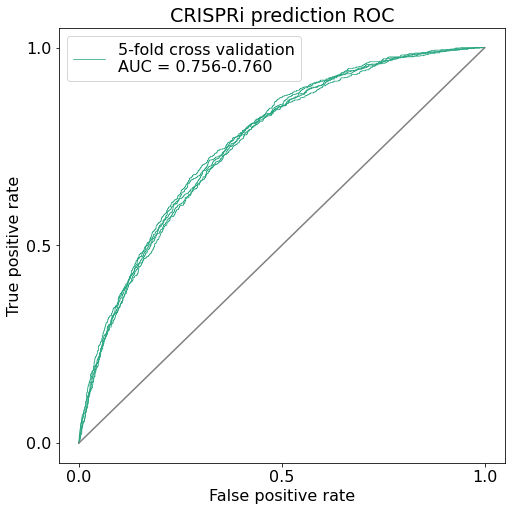

In [31]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

for i in range(len(models)):
    
    test_idxs = splits[i][1]

    preds_arr = models[i].predict(features_arr_std[test_idxs])
    scores_bin = scores_arr[test_idxs] > 0.75
    
    fpr, tpr, thresholds = metrics.roc_curve(scores_bin, preds_arr)
    ax1.plot(fpr, tpr, lw=0.75, color="#2aa782", label='5-fold cross validation\nAUC = 0.756-0.760')
    
    if i == 0:
        ax1.legend()
    
ax1.plot(np.array([0,1]), np.array([0,1]), color="gray")
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate")
ax1.set_xticks(np.array([0, 0.5, 1]))
ax1.set_yticks(np.array([0, 0.5, 1]))
ax1.set_title("CRISPRi prediction ROC")
plt.show()

---

## TODO: Figure 1C

In [43]:
cols = features_df.columns

def find_comp(string, nucl):
    prog = re.compile('^' + nucl + '_comp')
    result = prog.match(string)
    return bool(result)

def find_dimer_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z][A-Z]$')
    result = prog.match(string)
    return bool(result)

def find_nucl_pos(string):
    prog = re.compile('pos_-[0-9]+_[A-Z]$')
    result = prog.match(string)
    return bool(result)

def find_contribution(model, idxs):
    contr = np.sum(features_arr_std[:, idxs] * model.coef_[idxs], axis=1)
    ile_sub_contr = np.percentile(contr, 95) - np.percentile(contr, 5)
    return ile_sub_contr

In [48]:
nucls = ['A', 'C', 'G', 'T']
contrs = []
    
for model in models:
    
    comp_contr = np.sum([
        find_contribution(model, [find_comp(col, nucl) for col in cols]) for nucl in nucls
    ])
    
    TSS_contr = find_contribution(model, ['dist' in col for col in cols])
        
    run_contr = np.sum([
        find_contribution(model, ['longest_' + nucl in col for col in cols]) for nucl in nucls
    ])
    
    strand_contr = find_contribution(model, ['+ve' in col for col in cols])
    
    len_contr = find_contribution(model, ['length' in col for col in cols])
    
    nucl_contr = find_contribution(model, [find_nucl_pos(col) for col in cols])
    
    dimer_contr = find_contribution(model, [find_dimer_pos(col) for col in cols])
    
    contr = [
        comp_contr, TSS_contr, run_contr, strand_contr, 
        len_contr, nucl_contr, dimer_contr
    ]
    
    contrs.append(contr)

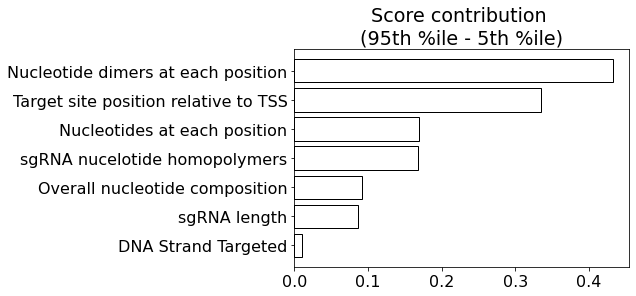

In [47]:
contr = [
    comp_contr, TSS_contr, run_contr, strand_contr, 
    len_contr, nucl_contr, dimer_contr
]

sorted_indices = np.argsort(contr)
contr = np.sort(contr)

labels = np.array([
    "Overall nucleotide composition",
    "Target site position relative to TSS", 
    "sgRNA nucelotide homopolymers",
    "DNA Strand Targeted",
    "sgRNA length",
    "Nucleotides at each position",
    "Nucleotide dimers at each position"
])[sorted_indices]

plt.barh(labels, contr, color = 'w',  edgecolor='k')
plt.title('Score contribution \n(95th %ile - 5th %ile)')
plt.show()

---

## TODO: Figure 1D

In [1]:
plt.scatter(preds, scores_arr)

NameError: name 'plt' is not defined

## TODO: Other Models